
------------------------------------------------------------
Baseline
------------------------------------------------------------
Avg Profit per Order: ₹48.26
Loss Risk: 2.20%
Order Volume (% of base): 100.0%
Monthly Profit: ₹318.52 Cr
Notes: FY24 baseline economics

------------------------------------------------------------
Scenario A: Increase Delivery Fee (+₹5)
------------------------------------------------------------
Avg Profit per Order: ₹51.31
Loss Risk: 1.82%
Order Volume (% of base): 97.0%
Monthly Profit: ₹328.52 Cr
Notes: Higher fee, slight churn, slightly higher CAC

------------------------------------------------------------
Scenario B: Reduce Refund Probability (2% → 1%)
------------------------------------------------------------
Avg Profit per Order: ₹52.70
Loss Risk: 1.02%
Order Volume (% of base): 97.0%
Monthly Profit: ₹337.36 Cr
Notes: Fewer refunds, slight drop in new user confidence

------------------------------------------------------------
Scenario C: Red

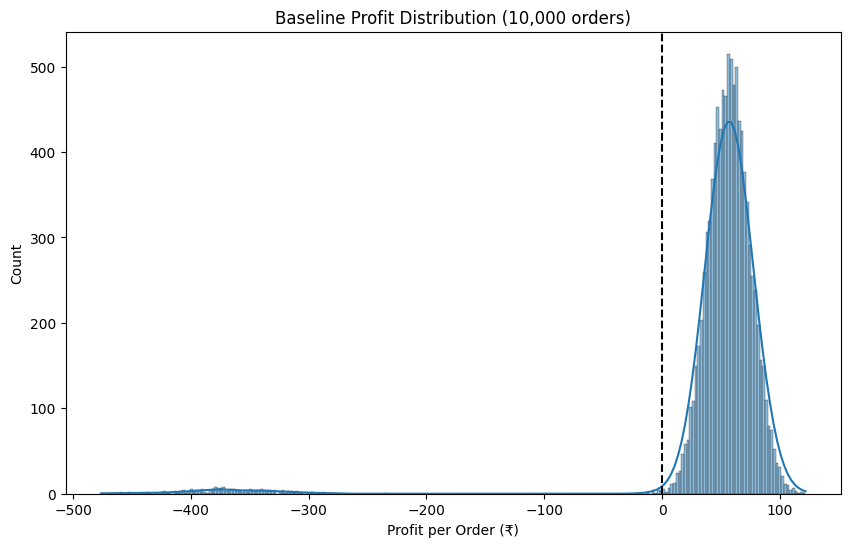

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 0. GLOBAL SETTINGS
# -------------------------------
SIMULATIONS = 10_000
BASE_MONTHLY_ORDERS = 66_000_000   # Zomato FY24 monthly order volume
np.random.seed(42)

# -------------------------------
# 1. BASELINE ASSUMPTIONS (FY24-STYLE)
# -------------------------------
BASE_PARAMS = {
    "AOV_MEAN": 428,
    "AOV_SD": 50,

    "COMMISSION_RATE": 0.225,
    "DELIVERY_FEE": 35,

    "RIDER_MEAN": 32,
    "RIDER_SD": 10,

    "PACK_MEAN": 12,
    "PACK_SD": 3,

    "MKT_MEAN": 20,
    "MKT_SD": 10,

    "GATEWAY_RATE": 0.024,
    "RETURN_PROB": 0.02
}

# -------------------------------
# 2. MONTE CARLO SIMULATION
# -------------------------------
def run_simulation(params, n_orders=SIMULATIONS, return_profit_array=False):
    aov = np.random.normal(params["AOV_MEAN"], params["AOV_SD"], n_orders)
    rider_cost = np.random.normal(params["RIDER_MEAN"], params["RIDER_SD"], n_orders)
    packaging_cost = np.random.normal(params["PACK_MEAN"], params["PACK_SD"], n_orders)
    marketing_cost = np.random.normal(params["MKT_MEAN"], params["MKT_SD"], n_orders)

    gateway_fee = aov * params["GATEWAY_RATE"]
    refund_flag = np.random.binomial(1, params["RETURN_PROB"], n_orders)
    refund_loss = aov * refund_flag

    revenue = aov * params["COMMISSION_RATE"] + params["DELIVERY_FEE"]
    total_cost = rider_cost + packaging_cost + marketing_cost + gateway_fee + refund_loss

    profit = revenue - total_cost

    avg_profit = profit.mean()
    loss_prob = (profit < 0).mean() * 100

    if return_profit_array:
        return avg_profit, loss_prob, profit
    else:
        return avg_profit, loss_prob


# -------------------------------
# 3. DEFINE SCENARIOS
# -------------------------------
scenarios = [
    {
        "name": "Scenario A: Increase Delivery Fee (+₹5)",
        "params": {**BASE_PARAMS, "DELIVERY_FEE": 40, "MKT_MEAN": 23},
        "order_mult": 0.97,
        "note": "Higher fee, slight churn, slightly higher CAC"
    },
    {
        "name": "Scenario B: Reduce Refund Probability (2% → 1%)",
        "params": {**BASE_PARAMS, "RETURN_PROB": 0.01},
        "order_mult": 0.97,
        "note": "Fewer refunds, slight drop in new user confidence"
    },
    {
        "name": "Scenario C: Reduce Rider Cost Variance (SD 10 → 6)",
        "params": {**BASE_PARAMS, "RIDER_SD": 6},
        "order_mult": 0.99,
        "note": "More predictable operations; small ops friction"
    },
    {
        "name": "Scenario D: Reduce CAC (₹20 → ₹10)",
        "params": {**BASE_PARAMS, "MKT_MEAN": 10},
        "order_mult": 0.95,
        "note": "Lower CAC improves margins but slows new user growth"
    },
    {
        "name": "Scenario E: Increase Commission (22.5% → 25%)",
        "params": {**BASE_PARAMS, "COMMISSION_RATE": 0.25},
        "order_mult": 0.98,
        "note": "Higher take rate with mild restaurant churn risk"
    }
]

# Add baseline at top
scenarios.insert(0, {
    "name": "Baseline",
    "params": BASE_PARAMS.copy(),
    "order_mult": 1.0,
    "note": "FY24 baseline economics"
})


# -------------------------------
# 4. RUN SCENARIOS + PRINT RESULTS
# -------------------------------
results = []
baseline_profit_array = None

for sc in scenarios:
    if sc["name"] == "Baseline":
        avg_p, loss_p, prof_arr = run_simulation(sc["params"], return_profit_array=True)
        baseline_profit_array = prof_arr
    else:
        avg_p, loss_p = run_simulation(sc["params"])

    monthly_orders = BASE_MONTHLY_ORDERS * sc["order_mult"]
    monthly_profit = avg_p * monthly_orders

    print("\n" + "-"*60)
    print(f"{sc['name']}")
    print("-"*60)
    print(f"Avg Profit per Order: ₹{avg_p:.2f}")
    print(f"Loss Risk: {loss_p:.2f}%")
    print(f"Order Volume (% of base): {sc['order_mult']*100:.1f}%")
    print(f"Monthly Profit: ₹{monthly_profit/1e7:.2f} Cr")
    print(f"Notes: {sc['note']}")

    results.append({
        "Scenario": sc["name"],
        "Avg Profit/order (₹)": round(avg_p, 2),
        "Loss Risk (%)": round(loss_p, 2),
        "Order Volume (%)": round(sc["order_mult"] * 100, 1),
        "Monthly Profit (₹ Cr)": round(monthly_profit / 1e7, 2),
        "Notes": sc["note"]
    })

results_df = pd.DataFrame(results)

print("\n\nFINAL COMPARISON TABLE:")
print(results_df)


# -------------------------------
# 5. BASELINE GRAPH ONLY
# -------------------------------
plt.figure(figsize=(10, 6))
sns.histplot(baseline_profit_array, kde=True)
plt.axvline(0, color='black', linestyle='--')
plt.title("Baseline Profit Distribution (10,000 orders)")
plt.xlabel("Profit per Order (₹)")
plt.ylabel("Count")
plt.show()
